In [1]:
library(hise)
library(dplyr)
library(ggplot2)
library(stats)
library(tidyverse)
library(readxl)
library(parallel)
library(ggpubr)
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     

In [2]:
df<-read.csv("../Figure4/10_Isotype_MSD/Isotype_MSD_Processed.csv")

In [3]:
df_filtered<-df %>%
    group_by(Assay, Isotype, subjectGuid) %>%
    mutate(count = n()) %>%
    filter(count == 2)

In [4]:
Ratio<-df_filtered %>% ungroup() %>% filter(Isotype %in% c("IgG2","IgG3")) %>%
    group_by(Assay, Flu_Day, subjectGuid) %>%
    mutate(count = n()) %>%
    filter(count == 2)%>% ungroup() %>% 
group_by(subjectGuid,Flu_Day,Assay) %>% 
arrange(Isotype) %>%
mutate(IgG2_IgG3_Ratio= first(`log.10.Calc..Conc..Mean`)/`log.10.Calc..Conc..Mean` )

In [5]:
meta_data <- read.csv("/home//workspace/IHA_Figure_Revision/Dataset/scRNA_meta_data-2024-05-09.csv")
df<-readr::read_csv('../Figure5/04_TCR_Stim_Exp/annotated1.csv')
df<-left_join(df,unique(meta_data[c('subjectGuid','CMV')]),
              by =c("donor"="subjectGuid"))

Rows: 6937027 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): condition, donor, time, group, cell_type, L1, L2, L3, L4, Final_Ce...
dbl (22): FSC, FSC-H, SSC, SSC-B, SSC-B-H, SSC-H, CCR7, IFNg, CD3, CD45RA, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
Ratio_subset<-df_filtered %>% ungroup() %>% filter(Isotype %in% c("IgG2","IgG3")) %>%
    group_by(Assay, Flu_Day, subjectGuid) %>%
    mutate(count = n()) %>%
    filter(count == 2)%>% ungroup() %>% 
group_by(subjectGuid,Flu_Day,Assay) %>% 
arrange(Isotype) %>%
mutate(IgG2_IgG3_Ratio= first(`log.10.Calc..Conc..Mean`)/`log.10.Calc..Conc..Mean` )%>%
    filter(Isotype == "IgG3",Assay=="Flu B/Phuket HA")

In [7]:
freq_df<-df %>%
    mutate(Final_Celltype=paste(L4,L2,L1))%>%
    group_by(donor, condition, Final_Celltype) %>%
    summarise(count = n()) %>%
    group_by(donor, condition) %>%
    dplyr::mutate(percentage = (count/sum(count)) * 100) %>%
    dplyr::mutate(percentage_clr = clr_transform((percentage)))

`summarise()` has grouped output by 'donor', 'condition'. You can override
using the `.groups` argument.


In [8]:
df_combined<-left_join(freq_df %>% filter(condition=="TCR"),Ratio_subset , 
                       by =c("donor"="subjectGuid"))

Warning message in left_join(freq_df %>% filter(condition == "TCR"), Ratio_subset, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [9]:
unique(df_combined$Final_Celltype)


[1] "IFNg+ IL4+ Memory CD4+" "IFNg+ IL4+ Memory CD8+" "IFNg+ IL4- Memory CD4+"
 [4] "IFNg+ IL4- Memory CD8+" "IFNg- IL4+ Memory CD4+" "IFNg- IL4+ Memory CD8+"
 [7] "IFNg- IL4- Memory CD4+" "IFNg- IL4- Memory CD8+" "NA Naive CD4+"         
[10] "NA Naive CD8+"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


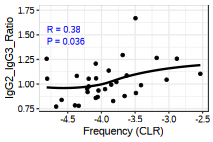

In [12]:


options(repr.plot.width = 40/25.4, repr.plot.height =  60/25.4)

p <- ggplot(data = df_combined %>%filter(!is.na(Flu_Day ),Flu_Day=="Day_7",Final_Celltype=="IFNg+ IL4+ Memory CD8+") %>% 
    filter(grepl("IL4\\+", Final_Celltype), grepl("IFNg\\+", Final_Celltype)),mapping = aes(y = IgG2_IgG3_Ratio, x = percentage_clr)) +
  geom_point(size = 0.6, stroke = 0.25) +
  geom_smooth(method = 'loess', color = "black", se = FALSE, span = 1.8,linewidth = 0.5) +
  stat_cor(
    method = "spearman",
    aes(label = paste0("R = ", ..r.., "\nP = ", ..p..)),
    label.x.npc = "left", 
    label.y.npc = "top",   output.type = "text",
color ="blue",
    size = 1.76
  ) +
  theme_bw(base_size = 6) + scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) + theme(
  axis.title   = element_text(color = "black"),
  axis.text    = element_text(color = "black"),
    strip.text.x      = element_text(margin = margin(t = 1, b = 1))


)+xlab("Frequency (CLR)")
options(repr.plot.width = 45/25.4, repr.plot.height =  30/25.4)

p
ggsave('FigureJ.pdf',
       p, width = 45/25.4,
       height = 30/25.4)